In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import graphviz
from sklearn import datasets
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.pyplot import figure

In [2]:
path = "~/Documents/Career Foundry/specialization/Data Sets"

In [3]:
df = pd.read_pickle(os.path.join(path, 'Dataset_scaled.pkl'))

In [4]:
answers = pd.read_csv(os.path.join(path, 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))

In [5]:
climate = df[~df['city'].isin(['GDANSK','ROMA','TOURS'])].copy()

In [6]:
climate.drop(columns=['wind_speed', 'snow_depth', 'pressure', 'cloud_cover'], inplace=True)

In [7]:
oslo_humidity = climate[climate['city'] == 'OSLO'].set_index('DATE')['humidity']
climate.loc[climate['city'] == 'STOCKHOLM', 'humidity'] = climate.loc[climate['city'] == 'STOCKHOLM', 'DATE'].map(oslo_humidity)

In [8]:
# Convert from wide format to long format using melt
ans_long = answers.melt(id_vars=['DATE'], 
                 var_name='city_metric', 
                 value_name='value')

# Split city name from variables and pivot them into new columns
ans_long[['city', 'metric']] = ans_long['city_metric'].str.split('_', n=1, expand=True)
ans_long = ans_long.drop('city_metric', axis=1).pivot_table(
   index=['DATE', 'city'], 
   columns='metric', 
   values='value', 
   aggfunc='first'
).reset_index()

In [9]:
ans_long['DATE'] = pd.to_datetime(ans_long['DATE'], format='%Y%m%d', errors='coerce')

In [10]:
climate = climate.sort_values(['DATE','city']).reset_index(drop=True)
pleasant = ans_long.sort_values(['DATE','city']).reset_index(drop=True)

In [31]:
print(climate[['DATE','city']])
print(pleasant[['DATE','city']])

metric       DATE        city
0      1960-01-01       BASEL
1      1960-01-01    BELGRADE
2      1960-01-01    BUDAPEST
3      1960-01-01      DEBILT
4      1960-01-01  DUSSELDORF
...           ...         ...
344245 2022-10-31    MUNCHENB
344246 2022-10-31        OSLO
344247 2022-10-31   SONNBLICK
344248 2022-10-31   STOCKHOLM
344249 2022-10-31    VALENTIA

[344250 rows x 2 columns]
metric       DATE        city
0      1960-01-01       BASEL
1      1960-01-01    BELGRADE
2      1960-01-01    BUDAPEST
3      1960-01-01      DEBILT
4      1960-01-01  DUSSELDORF
...           ...         ...
344245 2022-10-31    MUNCHENB
344246 2022-10-31        OSLO
344247 2022-10-31   SONNBLICK
344248 2022-10-31   STOCKHOLM
344249 2022-10-31    VALENTIA

[344250 rows x 2 columns]


In [11]:
#Create an 'X' matrix by dropping the unneeded columns.
X = climate.drop(['DATE', 'MONTH', 'city'], axis=1)
y = pleasant.pleasant_weather

In [12]:
#Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(258187, 7)
(86063, 7)
(258187,)
(86063,)


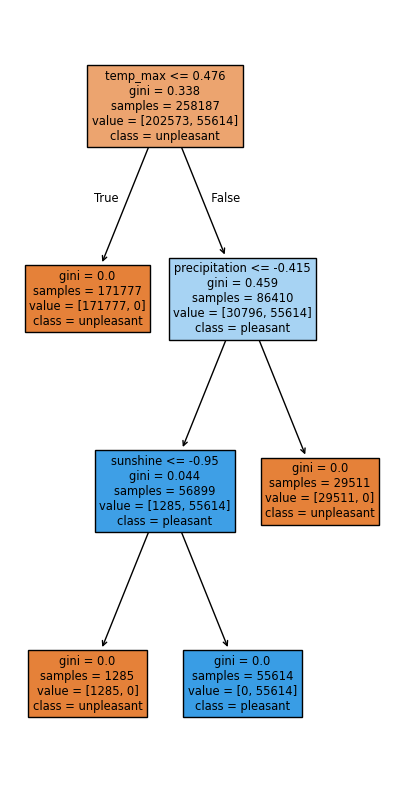

In [44]:
#Run Decision Tree classifier
weather_dt = DecisionTreeClassifier(criterion='gini', min_samples_split=2)
weather_dt.fit(X_train, y_train)
figure(figsize=(5,10))
tree.plot_tree(weather_dt, 
               feature_names=X_train.columns,           # Pass column names
               class_names=['unpleasant', 'pleasant'],  # Class labels
               filled=True)                             # Color by class composition
plt.show()

In [20]:
#What is the training accuracy score? Using the cross validation method
y_pred_train = weather_dt.predict(X_train)
print('Train accuracy score: ',cross_val_score(weather_dt, X_train, y_train, cv = 3, scoring='accuracy').mean())

Train accuracy score:  1.0


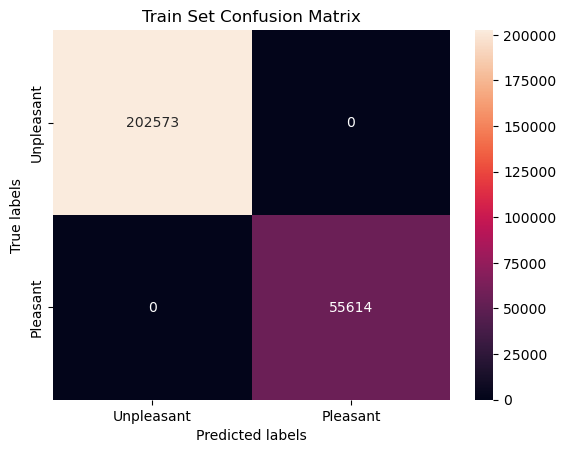

In [43]:
labels = ['Unpleasant','Pleasant']
ax= plt.subplot()

cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Train Set Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

plt.show()

In [45]:
y_pred = weather_dt.predict(X_test)
print('Test accuracy score: ',accuracy_score(y_test, y_pred))
multilabel_confusion_matrix(y_test, y_pred)

Test accuracy score:  1.0


array([[[18402,     0],
        [    0, 67661]],

       [[67661,     0],
        [    0, 18402]]])

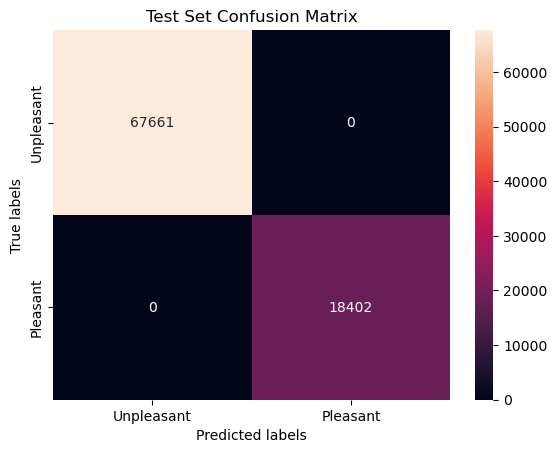

In [46]:
labels = ['Unpleasant','Pleasant']    

ax= plt.subplot()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Test Set Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

plt.show()